Library import and data loading 

In [17]:


if 'libraries_imported' not in globals():
    libraries_imported = False

if not libraries_imported:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from datetime import datetime, timedelta

    # Plotly libraries
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.io as pio

    # SciPy libraries
    from scipy.interpolate import make_interp_spline
    from scipy.signal import butter, filtfilt

    # TensorFlow and Keras for neural networks
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.regularizers import l1_l2
    from tensorflow.keras.models import load_model

    # Scikit-learn for model preparation and evaluation
    from sklearn.model_selection import train_test_split, KFold, GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_absolute_error

    # Ensemble and boosting models
    from xgboost import XGBRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.tree import DecisionTreeRegressor

    # Additional utilities
    import logging
    import joblib 
    import matplotlib.dates as mdates


        


    logging.getLogger('tensorflow').setLevel(logging.ERROR)

    # Optionally, to suppress absl (used by TensorFlow) messages as well:
    from absl import logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)


    # Placeholder for DataFrame
    df_annotations = None

    # Set plot size for Seaborn
    sns.set(rc={'figure.figsize':(17,8.27)})

    # Set the flag to True to indicate libraries are imported
    libraries_imported = True

# Set plot size for Seaborn (outside the if condition)
sns.set(rc={'figure.figsize':(17,8.27)})


Functions 

In [18]:

def apply_fig_format(fig_x, w=2000, h=600, subplot=False, n_cols=1, n_rows=1):
    xaxis_args=dict(
            tickfont=dict(size=18),
            title_font=dict(size=22),
            gridcolor='lightgray',
            linecolor='gray',
            linewidth=1,
            mirror=True,
            showline=True,
            dtick='D'
        )
    yaxis_args=dict(
            tickfont=dict(size=18),
            title_font=dict(size=22),
            gridcolor='lightgray',
            linecolor='gray',
            linewidth=1,
            mirror=True,
            showline=True,
        )

    fig_x.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        width=w,
        height=h,
     )

    if subplot:
        for i in range(1, n_cols*n_rows+1):
            fig_x['layout']['xaxis'+str(i)].update(xaxis_args)
            fig_x['layout']['yaxis'+str(i)].update(yaxis_args)
    else:
        fig_x['layout']['xaxis'].update(xaxis_args)
        fig_x['layout']['yaxis'].update(yaxis_args)




    fig_x.show()


def apply_date_range_df(df):
  df = df[df['datetime'].dt.date >= date_start]
  df = df[df['datetime'].dt.date <= date_end]
  return df

### Load in phase 1 and 2 data produce combined Dataset and refit model to this

In [19]:



def preprocess_dataframe(df, columns_to_drop):
    # Interpolate missing values
    df_interpolated = df.interpolate(method='linear')
    df_interpolated_bfilled = df_interpolated.bfill()

    # Drop unnecessary columns
    df_preprocessed = df_interpolated_bfilled.drop(columns=columns_to_drop)

    # Convert 'datetime' to datetime object and set it as index
    df_preprocessed['datetime'] = pd.to_datetime(df_preprocessed['datetime'])
    df_preprocessed = df_preprocessed.groupby('datetime').mean()

    # Create lagged features
    df_preprocessed['A Current_daily_avg_lag1d_dt'] = df_preprocessed['A Current_daily_avg'].shift(freq='1D')
    df_preprocessed['ntp_volume_this_tip_intervalml_daily_avg_lag1d_dt'] = df_preprocessed['ntp_volume_this_tip_intervalml_daily_avg'].shift(freq='1D')

    # Backfill any remaining missing values
    df_preprocessed = df_preprocessed.bfill()

    # Reset the index
    df_preprocessed.reset_index(inplace=True)
    
    return df_preprocessed

# Load your datasets
test_df = pd.read_csv('dataset2.csv')
original_dataset = pd.read_csv('dataset1.csv')

# Columns to drop
columns_to_drop = ['TSS', 'COD_kg/m3', 'VS', 'TE', 'TS', 'sample_vol', 'index', 'VFA', 'Unnamed: 0', 'CH4%', 'CO2', 'H2S']

# Apply preprocessing
original_dataset = preprocess_dataframe(original_dataset, columns_to_drop)
test_dataset = preprocess_dataframe(test_df, columns_to_drop)









df = test_dataset.copy()
date_series = df['datetime'].dt.date
date_list = date_series.tolist()
unique_dates = list(set(date_list))
sorted_unique_dates = sorted(unique_dates)
print(sorted_unique_dates)









combined_dataset = pd.concat([original_dataset, test_dataset.sample(frac=0.3)])
# combined_df = pd.concat([original_dataset, test_dataset.sample(frac=0.2)])

# num_rows = int(len(test_dataset) * 0.5)
# first_20_percent = test_dataset.iloc[:num_rows]
# combined_df = pd.concat([original_dataset, first_20_percent])



combined_df = combined_dataset.copy()
combined_df.drop(columns=['datetime'], inplace=True)  

# Prepare combined dataset for model training
X_combined = combined_df.drop(['sCOD_kg/m3'], axis=1)  
y_combined = combined_df['sCOD_kg/m3']

# Scale features
scaler = StandardScaler().fit(X_combined)
X_combined_scaled = scaler.transform(X_combined)



X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.4, random_state=20)

# Scale features (fit on training data only)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
best_model = load_model('model_phase2/model_0_KerasRegressor_model.h5')





best_model.fit(X_train_scaled, y_train)

# Validate on the newly created validation set
y_pred_val = best_model.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_pred_val)


print(f'Mean Absolute Error on Validation Set: {mae}')
test_dataset.drop(columns=['datetime'], inplace=True) 
X_test_new = scaler.transform(test_dataset.drop(['sCOD_kg/m3', 'datetime'], axis=1, errors='ignore')) 
y_pred = best_model.predict(X_test_new)
test_dataset.reset_index(inplace=True)



original_model = best_model



[datetime.date(2024, 1, 27), datetime.date(2024, 1, 28), datetime.date(2024, 1, 29), datetime.date(2024, 1, 30), datetime.date(2024, 1, 31), datetime.date(2024, 2, 1), datetime.date(2024, 2, 2), datetime.date(2024, 2, 3), datetime.date(2024, 2, 4)]
61/61 [==============================] - 0s 661us/step
Mean Absolute Error on Validation Set: 0.5709821586286907
37/37 [==============================] - 0s 809us/step


In [20]:
y_pred = y_pred.flatten().tolist()

trace1 = go.Scatter(
    x= df['datetime'],
    y=y_pred,
    mode='markers',
    marker=dict(color='blue', symbol='x'),
    name='Predicted',
    opacity=0.5
)

trace2 = go.Scatter(
    x= df['datetime'],
    y=test_dataset['sCOD_kg/m3'],
    mode='markers',
    marker=dict(color='red', symbol='circle'),
    name='Actual',
    opacity=0.5
)

# Create the figure
fig = go.Figure(data=[trace1, trace2])

# Update layout
fig.update_layout(
    title='Predicted sCOD over Time',
    xaxis_title='Datetime',
    yaxis_title= 'sCOD_kg/m3',
    xaxis=dict(
        # Uncomment and adjust the line below for datetime formatting, if needed
        # tickformat='%Y-%m-%d', 
        # tickmode='auto',  # or 'array', with tickvals and ticktext
    ),
    legend=dict(y=1, x=1),
    hovermode='closest',
    template='plotly',  # Choose a template as per your preference
    width=1200,  # Adjust the size as needed
    height=700
)



apply_fig_format(fig, 1200, 600)







### Phase 3 -- Baseline. Model retrained with frequency N (days), no real calibration data injected in feedback loop


5/5 [==============================] - 0s 2ms/step


/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



108/154 [====================>.........] - ETA: 0s - loss: 0.6468

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



 51/167 [========>.....................] - ETA: 0s - loss: 0.5384

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



 53/181 [=======>......................] - ETA: 0s - loss: 0.5651

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



 51/194 [======>.......................] - ETA: 0s - loss: 0.4679

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



 45/208 [=====>........................] - ETA: 0s - loss: 0.5266

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



5/5 [==============================] - 0s 892us/step


/tmp/ipykernel_53834/2895805967.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



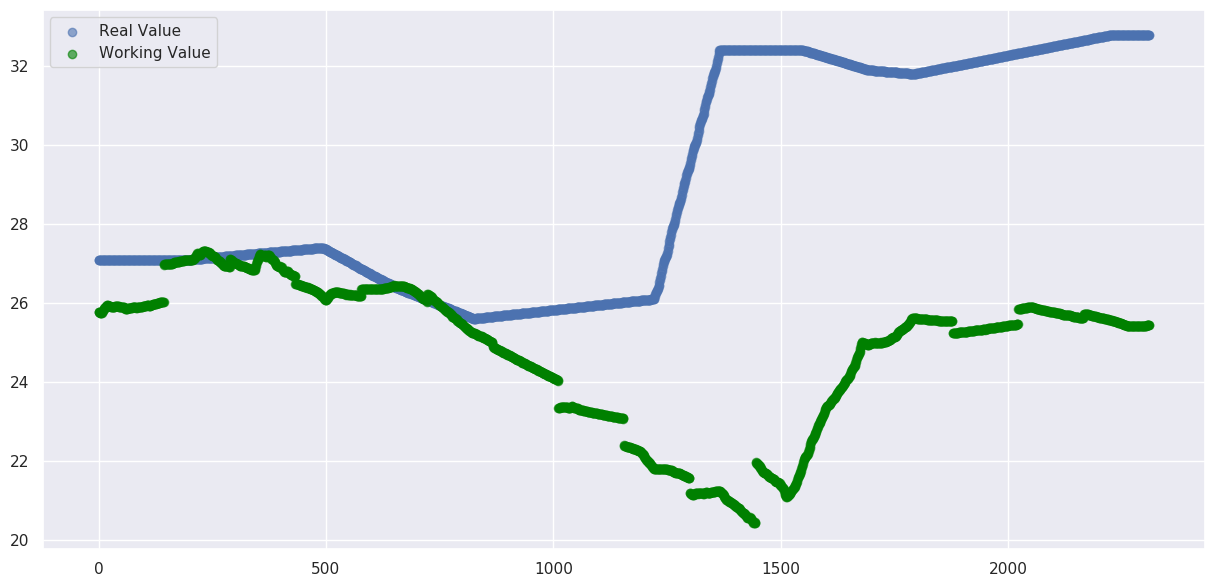

In [21]:
new_data = pd.read_csv('dataset3.csv') # real data to train inject into / validate model 3
new_data_processed = preprocess_dataframe(new_data, columns_to_drop)

date_series_new = new_data_processed['datetime'].dt.date
unique_dates_new = list(set(date_series_new))
sorted_unique_dates = sorted(unique_dates_new)


model = original_model

# Initialize dataframe for tracking predictions
tracking_df = pd.DataFrame(columns=['day', 'real', 'pred', 'working'])

# Iterate over each day in the new data
for day in sorted_unique_dates:
    # Extract day's data
    day_data = new_data_processed[new_data_processed['datetime'].dt.date == day]

    # Check if day_data is empty
    if day_data.empty:
        print(f"No data available for {day}, skipping this date.")
        continue

    # Drop 'datetime' and target column for prediction
    X_day = day_data.drop(['sCOD_kg/m3', 'datetime'], axis=1, errors='ignore')
    X_day_scaled = scaler.transform(X_day)

    # Predict using the model
    prediction = model.predict(X_day_scaled)

    # Get the real value
    real_value = day_data['sCOD_kg/m3'].values

    # Update the tracking dataframe
    tracking_df = tracking_df.append({'day': day, 'real': real_value, 'pred': prediction, 'working': prediction}, ignore_index=True)




    if tracking_df.shape[0] % 3 == 0:
        # Update new_data_processed with 'working' predictions before concatenation
        for index, row in tracking_df.iterrows():
            date = row['day']
            working_predictions = row['working']
            # Assuming new_data_processed has a matching date format and structure
            new_data_processed.loc[new_data_processed['datetime'].dt.date == date, 'sCOD_kg/m3'] = working_predictions

        # Combine the datasets for retraining
        combined_for_retraining = pd.concat([original_dataset, new_data_processed[new_data_processed['datetime'].dt.date <= day]])
        combined_for_retraining.drop(columns=['datetime'], inplace=True)

        # Prepare dataset for retraining
        X_retrain = combined_for_retraining.drop(['sCOD_kg/m3'], axis=1)
        y_retrain = combined_for_retraining['sCOD_kg/m3']  # Now uses updated 'working' predictions where applicable

        # Scale features for retraining
        X_retrain_scaled = scaler.transform(X_retrain)

        # Retrain the model
        model.fit(X_retrain_scaled, y_retrain)

        # Save the retrained model
        try:
            model.save(f'model_phase3_BLIND/dynamic_model_BLIND_day_{day}.h5')
        except Exception as e:
            pass




plt.figure(figsize=(15, 7))

# Using scatter plot for individual observations for real values


# Now, plot working data instead of predicted data. First, expand the working data similar to real and predicted values
expanded_rows_working = []
for index, row in tracking_df.iterrows():
    day = row['day']
    real_values = row['real']  # This remains the same
    working_values = row['working']  # Use working values, assuming they are not nested
    for real, working in zip(real_values, working_values):
        expanded_rows_working.append({'day': day, 'real': real, 'working': working})

expanded_df_working = pd.DataFrame(expanded_rows_working)

plt.scatter(range(len(expanded_df_working)), expanded_df_working['real'], label='Real Value', alpha=0.6)
plt.scatter(range(len(expanded_df_working)), expanded_df_working['working'], label='Working Value', alpha=0.6, color='green')

# Update the calculation for real_avg if necessary, or remove if not used in this context

plt.legend()
plt.show()


### Phase 3 -- Dynamic retrain. Real data injected into target column with frequency N (days), Model retrained with frequency N 

5/5 [==============================] - 0s 1ms/step


 45/154 [=======>......................] - ETA: 0s - loss: 0.4753

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



 41/167 [======>.......................] - ETA: 0s - loss: 0.4982

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



 50/181 [=======>......................] - ETA: 0s - loss: 0.5186

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



 30/194 [===>..........................] - ETA: 0s - loss: 0.5612

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



 55/208 [======>.......................] - ETA: 0s - loss: 0.4645

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



5/5 [==============================] - 0s 595us/step


/tmp/ipykernel_53834/2684106696.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



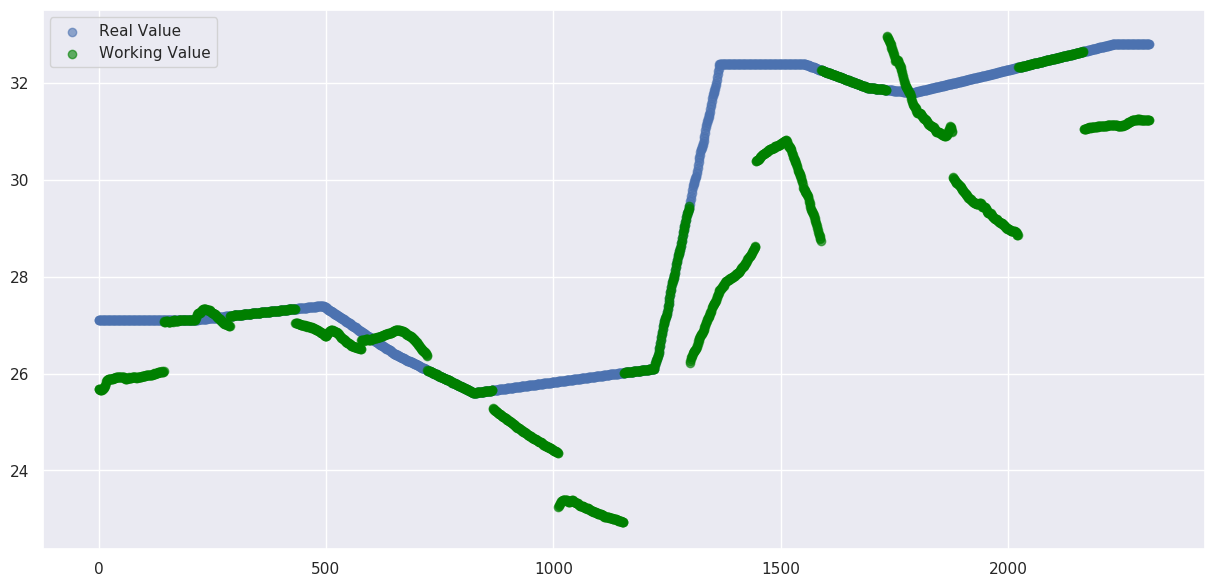

In [22]:
new_data = pd.read_csv('dataset3.csv')
new_data_processed = preprocess_dataframe(new_data, columns_to_drop)

date_series_new = new_data_processed['datetime'].dt.date
unique_dates_new = list(set(date_series_new))
sorted_unique_dates = sorted(unique_dates_new)


# Initialize dataframe for tracking predictions
tracking_df = pd.DataFrame(columns=['day', 'real', 'pred', 'working'])


model = original_model


# Iterate over each day in the new data
for day in sorted_unique_dates:
    # Extract day's data
    day_data = new_data_processed[new_data_processed['datetime'].dt.date == day]

    # Check if day_data is empty
    if day_data.empty:
        print(f"No data available for {day}, skipping this date.")
        continue

    # Drop 'datetime' and target column for prediction
    X_day = day_data.drop(['sCOD_kg/m3', 'datetime'], axis=1, errors='ignore')
    X_day_scaled = scaler.transform(X_day)

    # Predict using the model
    prediction = model.predict(X_day_scaled)

    # Get the real value
    real_value = day_data['sCOD_kg/m3'].values

    # Update the tracking dataframe
    tracking_df = tracking_df.append({'day': day, 'real': real_value, 'pred': prediction, 'working': prediction}, ignore_index=True)




    if tracking_df.shape[0] % 3 == 0:  # Trigger retraining at every 5th entry
        # Update the 'working' column for the current day with real values
        tracking_df.loc[tracking_df.index[-1], 'working'] = tracking_df.loc[tracking_df.index[-1], 'real']

        # Before retraining, update 'new_data_processed' with 'working' data
        for date, working_data in zip(tracking_df['day'], tracking_df['working']):
            new_data_processed.loc[new_data_processed['datetime'].dt.date == pd.to_datetime(date).date(), 'sCOD_kg/m3'] = working_data

            # Combine the datasets for retraining
            combined_for_retraining = pd.concat([original_dataset, new_data_processed[new_data_processed['datetime'].dt.date <= day]])
            combined_for_retraining.drop(columns=['datetime'], inplace=True)

            # Prepare dataset for retraining
            X_retrain = combined_for_retraining.drop(['sCOD_kg/m3'], axis=1)
            y_retrain = combined_for_retraining['sCOD_kg/m3']  # Now potentially includes updated 'working' values

            # Scale features for retraining
            X_retrain_scaled = scaler.transform(X_retrain)

            # Retrain the model
            model.fit(X_retrain_scaled, y_retrain)

            # Save the retrained model
            try:
                model.save(f'model_phase3_ACTIVE/model_day_{day}.h5')
            except Exception as e:
                pass

        


# display(tracking_df)

plt.figure(figsize=(15, 7))

# Using scatter plot for individual observations for real values


# Now, plot working data instead of predicted data. First, expand the working data similar to real and predicted values
expanded_rows_working = []
for index, row in tracking_df.iterrows():
    day = row['day']
    real_values = row['real']  # This remains the same
    working_values = row['working']  # Use working values, assuming they are not nested
    for real, working in zip(real_values, working_values):
        expanded_rows_working.append({'day': day, 'real': real, 'working': working})

expanded_df_working = pd.DataFrame(expanded_rows_working)

# Using scatter plot for individual observations for working values
plt.scatter(range(len(expanded_df_working)), expanded_df_working['real'], label='Real Value', alpha=0.6)
plt.scatter(range(len(expanded_df_working)), expanded_df_working['working'], label='Working Value', alpha=0.6, color='green')


# Update the calculation for real_avg if necessary, or remove if not used in this context

plt.legend()
plt.show()



### Phase 3 -- Dynamic retrain. Real data injected into target column with frequency N (days), Model retrained with frequency N. Only last layer retrained.

  1/163 [..............................] - ETA: 0s - loss: 0.2515

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



  1/185 [..............................] - ETA: 0s - loss: 0.4491

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



  1/208 [..............................] - ETA: 0s - loss: 0.5314

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



5/5 [==============================] - 0s 631us/step


/tmp/ipykernel_53834/2238327280.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



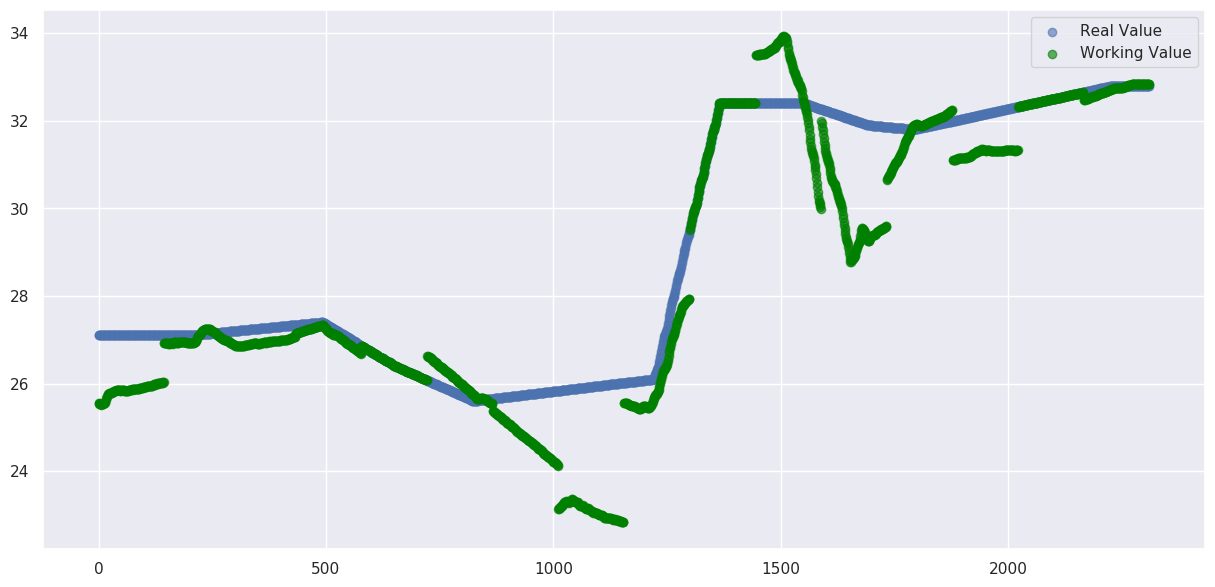

In [24]:
new_data = pd.read_csv('dataset3.csv')
new_data_processed = preprocess_dataframe(new_data, columns_to_drop)

date_series_new = new_data_processed['datetime'].dt.date
unique_dates_new = list(set(date_series_new))
sorted_unique_dates = sorted(unique_dates_new)

# Initialize dataframe for tracking predictions
tracking_df = pd.DataFrame(columns=['day', 'real', 'pred', 'working'])

model = original_model

# Freeze all layers except the last one
for layer in model.layers[:-1]:
    layer.trainable = False
# Ensure the last layer is trainable
model.layers[-1].trainable = True

# Iterate over each day in the new data
for day in sorted_unique_dates:
    # Extract day's data
    day_data = new_data_processed[new_data_processed['datetime'].dt.date == day]

    # Check if day_data is empty
    if day_data.empty:
        print(f"No data available for {day}, skipping this date.")
        continue

    # Drop 'datetime' and target column for prediction
    X_day = day_data.drop(['sCOD_kg/m3', 'datetime'], axis=1, errors='ignore')
    X_day_scaled = scaler.transform(X_day)

    # Predict using the model
    prediction = model.predict(X_day_scaled)

    # Get the real value
    real_value = day_data['sCOD_kg/m3'].values

    # Update the tracking dataframe
    tracking_df = tracking_df.append({'day': day, 'real': real_value, 'pred': prediction, 'working': prediction}, ignore_index=True)

    if tracking_df.shape[0] % 5 == 0:  # Adjusted to retrain at every 3rd entry for consistency with comment
        # Update the 'working' column for the current day with real values
        tracking_df.loc[tracking_df.index[-1], 'working'] = tracking_df.loc[tracking_df.index[-1], 'real']

        # Before retraining, update 'new_data_processed' with 'working' data
        for date, working_data in zip(tracking_df['day'], tracking_df['working']):
            new_data_processed.loc[new_data_processed['datetime'].dt.date == pd.to_datetime(date).date(), 'sCOD_kg/m3'] = working_data

            # Combine the datasets for retraining
            combined_for_retraining = pd.concat([original_dataset, new_data_processed[new_data_processed['datetime'].dt.date <= day]])
            combined_for_retraining.drop(columns=['datetime'], inplace=True)

            # Prepare dataset for retraining
            X_retrain = combined_for_retraining.drop(['sCOD_kg/m3'], axis=1)
            y_retrain = combined_for_retraining['sCOD_kg/m3']  # Now potentially includes updated 'working' values

            # Scale features for retraining
            X_retrain_scaled = scaler.transform(X_retrain)

            # Retrain the model (only the last layer)
            model.fit(X_retrain_scaled, y_retrain)

            # Save the retrained model
            try:
                model.save(f'model_phase3_ACTIVE2/model_day_{day}.h5')
            except Exception as e:
                print(f"Error saving the model: {e}")

# display(tracking_df)
plt.figure(figsize=(15, 7))

# Now, plot working data instead of predicted data. First, expand the working data similar to real and predicted values
expanded_rows_working = []
for index, row in tracking_df.iterrows():
    day = row['day']
    real_values = row['real']
    working_values = row['working']
    for real, working in zip(real_values, working_values):
        expanded_rows_working.append({'day': day, 'real': real, 'working': working})

expanded_df_working = pd.DataFrame(expanded_rows_working)

plt.scatter(range(len(expanded_df_working)), expanded_df_working['real'], label='Real Value', alpha=0.6)
plt.scatter(range(len(expanded_df_working)), expanded_df_working['working'], label='Working Value', alpha=0.6, color='green')

plt.legend()
plt.show()